In [95]:
import gym
from gym import spaces
import copy
import math
import random
import time
import numpy as np
from time import sleep
from random import sample
from itertools import count
from IPython import display
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt

import logging

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


In [96]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    logging.info(f'Running on {torch.cuda.get_device_name(0)}')
else:
    device = torch.device('cpu')

In [128]:
class MyEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    actions = {
        "idle" : 0,
        "left" : 1,
        "right" : 2,
        "up" : 3,
        "down" : 4
    }

    def __init__(self, size, num_obstacles, num_enemies):        
        super(MyEnv, self).__init__()
        self.size = size
        self.num_obstacles = num_obstacles
        self.num_enemies = num_enemies

        self.action_space = spaces.Discrete(5)
        self.hidden = 0.0
        self.passable = 0.1
        self.obstacle = 0.2        
        self.enemy = 0.3
        self.exit = 0.4
        self.agent = 0.5        

        self.grid = None

        self.obstacle_grid = None
        self.enemy_grid = None
        self.exit_grid = None
        self.agent_grid = None
        self.previous_positions_grid = None

        self.mask = None

        self.agent_position = None
        self.previous_positions = set()


    def reset_mask(self):
        self.mask = np.zeros((self.size+2, self.size+2))

    def get_mask(self, reset = False):
        if self.mask is None or reset:
            self.reset_mask()
        x = np.arange(0, 14)
        y = np.arange(0, 14)
        agent_y, agent_x  = self.agent_position[0], self.agent_position[1]
        fov = (x[np.newaxis,:]-agent_x)**2 + (y[:,np.newaxis]-agent_y)**2 < 2**2
        self.mask[fov] = 1

        return self.mask  

    def reset(self):
        #generates grid
        self.grid = np.ones((self.size+2, self.size+2))*self.obstacle
        self.grid[1:-1, 1:-1] = self.passable

        #generates obstacles
        self.obstacle_grid = np.ones((self.size+2, self.size+2))*1
        self.obstacle_grid[1:-1, 1:-1] = 0
        for i in range(self.num_obstacles):
            obstacle_location = (random.randint(1,self.size), random.randint(1,self.size))
            self.grid[obstacle_location] = self.obstacle
            self.obstacle_grid[obstacle_location] = 1

        #generates enemies
        self.enemy_grid = np.zeros((self.size+2, self.size+2))
        for i in range(self.num_enemies):
            enemy_location = (random.randint(1,self.size), random.randint(1,self.size))
            self.grid[enemy_location] = self.enemy
            self.enemy_grid[enemy_location] = 1

        #generates exit
        self.exit_grid = np.zeros((self.size+2, self.size+2))
        exit_location = (random.randint(1,self.size), random.randint(1,self.size))
        self.grid[exit_location] = self.exit
        self.exit_grid[exit_location] = 1
        #generates agent position
        self.previous_positions = set()

        self.agent_grid = np.zeros((self.size+2, self.size+2))
        self.previous_positions_grid = np.zeros((self.size+2, self.size+2))

        self.agent_position = (random.randint(1,self.size), random.randint(1,self.size))        
        self.grid[self.agent_position] = self.agent

        self.agent_grid[self.agent_position] = 1
        self.previous_positions_grid[self.agent_position] = 1
        
        self.previous_positions.add(self.agent_position)
        
        self.mask = self.get_mask(reset = True)
        
        # state_tensor = torch.FloatTensor([self.obstacle_grid * self.mask,
        #                                 self.enemy_grid * self.mask,
        #                                 self.exit_grid * self.mask,
        #                                 self.agent_grid * self.mask,
        #                                 self.previous_positions_grid * self.mask
        #                                 ])

        state_tensor = torch.FloatTensor([self.obstacle_grid,
                                        self.enemy_grid,
                                        self.exit_grid,
                                        self.agent_grid,
                                        self.previous_positions_grid
                                        ])

        return state_tensor

    def step(self, action):
        reward = 0
        done = False
        
        agent_y, agent_x = self.agent_position[0], self.agent_position[1]               

        if action == self.actions["idle"]:
            pass
        elif action == self.actions["left"]:
            agent_y, agent_x = agent_y, agent_x-1            
        elif action == self.actions["right"]:
            agent_y, agent_x = agent_y, agent_x+1                     
        elif action == self.actions["up"]:
            agent_y, agent_x = agent_y-1, agent_x                       
        elif action == self.actions["down"]:
            agent_y, agent_x = agent_y+1, agent_x         

        agent_position_new = (agent_y, agent_x)

        if self.grid[agent_position_new] == self.obstacle:
            agent_position_new = self.agent_position

        elif self.grid[agent_position_new] == self.enemy:
            agent_position_new = self.agent_position            
            reward = 0
            done = True

        elif self.grid[agent_position_new] == self.exit:

            self.agent_grid[self.agent_position] = 0
            self.agent_grid[agent_position_new] = 1

            self.previous_positions_grid[self.agent_position] = 1
            reward = 1
            done = True

        elif self.grid[agent_position_new] == self.passable:            

            self.grid[self.agent_position] = self.passable
            self.grid[agent_position_new] = self.agent           

            self.agent_grid[self.agent_position] = 0
            self.agent_grid[agent_position_new] = 1
            self.previous_positions_grid[self.agent_position] = 1
        
        self.agent_position = agent_position_new 

        if self.agent_position in self.previous_positions:
            reward *= 0.5
        else:
            reward +=0.01
        
        self.previous_positions.add(self.agent_position)

        self.mask = self.get_mask()

        # state_tensor = torch.FloatTensor([self.obstacle_grid * self.mask,
        #                                 self.enemy_grid * self.mask,
        #                                 self.exit_grid * self.mask,
        #                                 self.agent_grid * self.mask,
        #                                 self.previous_positions_grid * self.mask
        #                                 ])

        state_tensor = torch.FloatTensor([self.obstacle_grid,
                                        self.enemy_grid,
                                        self.exit_grid,
                                        self.agent_grid,
                                        self.previous_positions_grid
                                        ])

        return state_tensor, reward, done, {}   

    def render(self, mode='human'):
        return self.grid * self.mask


In [129]:
env = MyEnv(size=12, num_obstacles=12, num_enemies=2)
env.reset()
print("-")

-


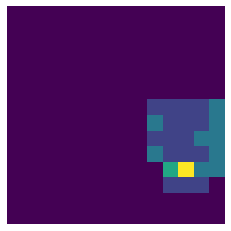

In [132]:
env.reset()
sample_state = env.render()
sample_img = plt.imshow(env.render(mode='rgb_array'))
for j in range(100):    
    sleep(0.05)
    sample_action = env.action_space.sample()    
    state, reward, done, _ = env.step(sample_action)
    #print(f"Sample action: {sample_action}, {list(env.actions.keys())[list(env.actions.values()).index(sample_action)]}, Reward: {reward}, Done: {done}", end = "")
    sample_img.set_data(env.render(mode='rbg_array'))
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    if done:
        break

In [147]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super(QNetwork,self).__init__()
        self.seed = torch.manual_seed(seed)

        self.conv1 = nn.Conv2d(5, 128, 8, 1)
        self.conv2 = nn.Conv2d(128, 256, 4, 2)
        self.conv3 = nn.Conv2d(256, 512, 2, 2)
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, action_size)  
    
    def forward(self, x):  
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.flatten(x)
        #print(x.size()) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return self.fc3(x)

In [148]:
from collections import namedtuple, deque 

buffer_size = 100000
batch_size = 64
gamma = 0.9999
tau = 0.0001
learning_rate = 0.0001
update_rate = 5

class Agent():    
    def __init__(self, state_size, action_size, seed):       
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device) 
        self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr = learning_rate)
        self.memory = deque(maxlen=buffer_size)
        self.experiences = namedtuple("Experience", field_names=["state",
                                                               "action",
                                                               "reward",
                                                               "next_state",
                                                               "done"])
        self.t_step = 0
        self.total_loss = []      
        
    def step(self, state, action, reward, next_state, done):
        self.memory.append(self.experiences(state, action, reward, next_state, done))        

        self.t_step = (self.t_step+1) % update_rate
        
        if self.t_step == 0:
            if len(self.memory) > batch_size*3:
                experience = random.sample(self.memory, batch_size)
                #experience = [self.memory.popleft() for item in range(batch_size)]
                self.learn(experience, gamma)

    def act(self, state, eps = 0):        
        if random.random() > eps:
            state = state.unsqueeze(0).to(device)
            self.qnetwork_local.eval()
            with torch.no_grad():
                action_values = self.qnetwork_local(state)
            self.qnetwork_local.train()
            action =  np.argmax(action_values.cpu().data.numpy())
        else:
            action = random.choice(np.arange(self.action_size))
        
        return action
            
    def learn(self, experience, gamma):

        states = torch.from_numpy(np.stack([e.state for e in experience if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experience if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experience if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.stack([e.next_state for e in experience if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experience if e is not None]).astype(np.uint8)).float().to(device)

        criterion = torch.nn.SmoothL1Loss()
        #criterion = torch.nn.MSELoss()
        self.qnetwork_local.train()
        self.qnetwork_target.eval()
        predicted_targets = self.qnetwork_local(states).gather(1, actions)

        with torch.no_grad():
            labels_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)        
        labels = rewards + (gamma*labels_next*(1-dones))
        
        loss = criterion(predicted_targets, labels).to(device)
        self.total_loss.append(loss.item())

        self.optimizer.zero_grad()
        loss.backward()
        # for param in self.qnetwork_local.parameters():
        #     param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        
        self.soft_update(self.qnetwork_local, self.qnetwork_target, tau)        
            
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(),
                                           local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1-tau)*target_param.data)   


In [149]:
agent = Agent(state_size=196, action_size=5, seed=55555)

def training_loop(n_episodes = 25000, max_t = 100, eps_start = 1, eps_end = 0.15,
       eps_decay = 0.999):
    best_score = float("-inf")
    scores = []
    scores_window = deque(maxlen=1000)
    total_scores = []
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)            
            state = next_state
            score += reward
            if done:
                next_state = None
                break

        scores_window.append(score)
        scores.append(score)                        
            
        eps = max(eps*eps_decay, eps_end)
        print(f"\rEpisode: {i_episode}\tEpisode Score: {score:.5f}\tLast iters score: {np.mean(scores_window):.5f}\tEps: {eps:.2f}", end="")        
        if i_episode % 1000==0:
            print(f"\nEpisode {i_episode}\tAverage Score {np.mean(scores):.5f}\tAverage loss: {np.mean(agent.total_loss):.5f}")
            agent.total_loss = []
            total_scores.append(np.mean(scores))
            scores = []
            if np.mean(scores) > best_score:
                best_score = np.mean(scores)
                torch.save(agent.qnetwork_local.state_dict(), f"checkpoint_{best_score}.pth")
            
        if np.mean(scores_window) >= 1:
            print(f"\nEnvironment solved in {i_episode} epsiodes.\tAverage score: {np.mean(scores_window):.5f}")
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break        

    return scores

In [150]:
scores = training_loop()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Epsiode #')
plt.show()

Episode: 1000	Episode Score: 1.04000	Last iters score: 0.34956	Eps: 0.37
Episode 1000	Average Score 0.34956	Average loss: 0.00066
Episode: 2000	Episode Score: 0.18000	Last iters score: 0.28856	Eps: 0.15
Episode 2000	Average Score 0.28856	Average loss: 0.00051
Episode: 3000	Episode Score: 1.07000	Last iters score: 0.24221	Eps: 0.15
Episode 3000	Average Score 0.24221	Average loss: 0.00037
Episode: 4000	Episode Score: 0.01000	Last iters score: 0.23434	Eps: 0.15
Episode 4000	Average Score 0.23434	Average loss: 0.00022
Episode: 5000	Episode Score: 1.12000	Last iters score: 0.24201	Eps: 0.15
Episode 5000	Average Score 0.24201	Average loss: 0.00020
Episode: 6000	Episode Score: 0.13000	Last iters score: 0.23359	Eps: 0.15
Episode 6000	Average Score 0.23359	Average loss: 0.00019
Episode: 7000	Episode Score: 0.20000	Last iters score: 0.26484	Eps: 0.15
Episode 7000	Average Score 0.26484	Average loss: 0.00021
Episode: 8000	Episode Score: 1.01000	Last iters score: 0.26004	Eps: 0.15
Episode 8000	Aver

KeyboardInterrupt: 

In [138]:
torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')

In [142]:
agent = Agent(state_size = 196, action_size = 5, seed=55)
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(5):
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    reward_total = 0
    for j in range(50):
        sleep(0.1)
        action = agent.act(state)
        img.set_data(env.render(mode='rbg_array'))
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, _ = env.step(action)
        reward_total += reward
        if done:
            break
    print(reward_total)

env.close()

KeyboardInterrupt: 